In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd 
import geopandas as gpd
from glob import glob
import matplotlib.pyplot as plt 
import seaborn as sns
import altair as alt
import plotly.express as px
import numpy as np

In [ ]:
sf_data = pd.read_csv('/Users/florence/Desktop/citizen_science/sf_data_with_greenspace_flag.csv', index_col=0)

In [4]:
sf_data.greenspace_flag.value_counts()

0    97978
1    41060
Name: greenspace_flag, dtype: int64

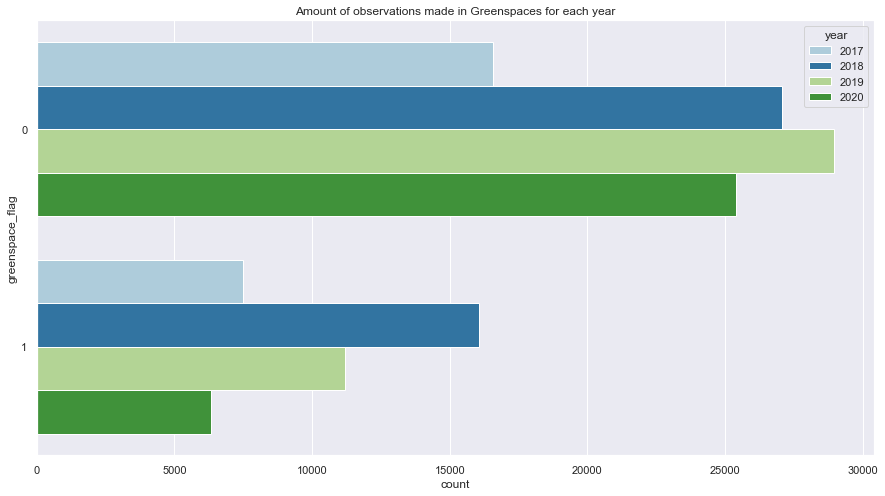

In [6]:
sf_data['time_observed_at'] = pd.to_datetime(sf_data['time_observed_at'], utc=True)
sf_data['year'] = pd.DatetimeIndex(sf_data['time_observed_at']).year
sns.set_theme(style="darkgrid")
plt.figure(figsize=(15,8))
plt.title('Amount of observations made in Greenspaces for each year')
ax = sns.countplot(y="greenspace_flag", hue="year", data=sf_data, palette='Paired')

In [8]:
fig = ax.get_figure()
fig.savefig("sf_greenspace_overview_absolute.png")

[Text(0.5, 0, 'amount of observations'), Text(0, 0.5, 'greenspace flag')]

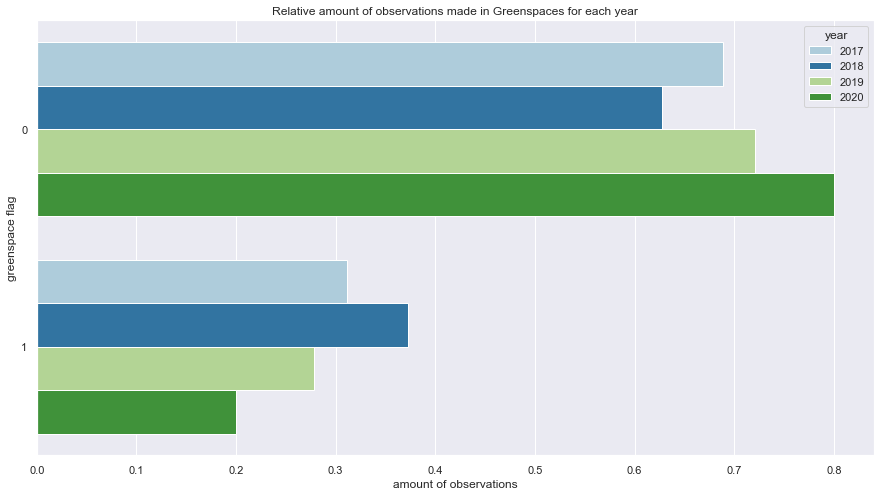

In [9]:
grouped_df = sf_data.groupby(['year', 'greenspace_flag']).count()['observed_on_string'].to_frame()
grouped_df.reset_index(inplace=True)
grouped_df.set_index(['year', 'greenspace_flag'], inplace=True)
grouped_df['proportions'] = 0.
for y in grouped_df.index.unique(level='year').tolist():
    grouped_df.at[(y, 0), 'proportions'] = grouped_df.loc[(y, 0), 'observed_on_string'] / (grouped_df.loc[(y, 0), 'observed_on_string'] + grouped_df.loc[(y, 1), 'observed_on_string'])
    grouped_df.at[(y, 1), 'proportions'] = grouped_df.loc[(y, 1), 'observed_on_string'] / (grouped_df.loc[(y, 0), 'observed_on_string'] + grouped_df.loc[(y, 1), 'observed_on_string'])
grouped_df.reset_index(inplace=True)
sns.set_theme(style="darkgrid")
plt.figure(figsize=(15,8))
plt.title('Relative amount of observations made in Greenspaces for each year')
ax = sns.barplot(x="proportions", y="greenspace_flag", hue="year", data=grouped_df, palette='Paired', orient='h')
ax.set(xlabel='amount of observations', ylabel='greenspace flag')

In [10]:
fig = ax.get_figure()
fig.savefig("sf_greenspace_overview_relative.png")

In [ ]:
sf_2018 = sf_data[sf_data.year == 2018]
# select the top-20 users: 
ranks = sf_2018.groupby('user_login').count()['year'].to_frame()
ranks.rename(columns={'year':'num_obsverations'}, inplace=True)
ranks.head()

In [ ]:
ranks.reset_index(inplace=True)
ranks.sort_values(by='num_obsverations', inplace=True, ascending=False)
ranks.head()

In [ ]:
top_20 = ranks.head(20)
top_20_users = top_20.user_login.values.tolist()
sf_top_20 = sf_2018[sf_2018['user_login'].isin(top_20_users)]
plt.figure(figsize=(15,8))
plt.title('Amount of observations made in greenspaces and non-greenspaces per user')
ax = sns.countplot(y="greenspace_flag", hue="user_login", data=sf_top_20, palette='Spectral')

In [ ]:
proportion_df = sf_top_20.groupby(['user_login', 'greenspace_flag']).size().to_frame()
proportion_df.reset_index(inplace=True)
proportion_df.rename(columns={0: 'num_observations'}, inplace=True)
proportion_df['proportion'] = 0
proportion_df.set_index(['user_login', 'greenspace_flag'], inplace=True)
for user in proportion_df.index.unique(level='user_login'):
    if (user, 1) in proportion_df.index.unique() and (user, 0) in proportion_df.index.unique():
        proportion_df.loc[user, 'proportion'] = proportion_df.loc[(user, 1), 'num_observations'] / (proportion_df.loc[(user, 1), 'num_observations'] + proportion_df.loc[(user, 0), 'num_observations'])
    elif (user, 0) not in proportion_df.index.unique(): 
        proportion_df.loc[user, 'proportion'] = 1.0
        
proportion_df['num_obs'] = 0
for user in proportion_df.index.unique(level='user_login'):
    if (user, 1) in proportion_df.index.unique() and (user, 0) in proportion_df.index.unique():
        proportion_df.loc[user, 'num_obs'] = proportion_df.loc[(user, 1), 'num_observations'] + proportion_df.loc[(user, 0), 'num_observations']
    elif (user, 0) not in proportion_df.index.unique() and (user, 1) in proportion_df.index.unique(): 
        proportion_df.loc[user, 'num_obs'] = proportion_df.loc[(user, 1), 'num_observations']
    elif (user, 0) in proportion_df.index.unique() and (user, 1) not in proportion_df.index.unique(): 
        proportion_df.loc[user, 'num_obs'] = proportion_df.loc[(user, 0), 'num_observations']

proportion_df.reset_index(inplace=True)
new_df = proportion_df.drop(columns=['greenspace_flag', 'num_observations'])
new_df.drop_duplicates(inplace=True)
plt.figure(figsize=(20,8))
plt.title('Proportion of observations made in greenspace per every user of top-20 users')
plt.xticks(rotation=45)
ax = sns.barplot(x="user_login", y="proportion", data=new_df, palette='Spectral')

### 2017:

In [ ]:
sf_17 = sf_data[sf_data.year == 2017]
all_proportions_17 = sf_17.groupby(['user_login', 'greenspace_flag']).size().to_frame()
all_proportions_17.reset_index(inplace=True)
all_proportions_17.rename(columns={0: 'num_observations'}, inplace=True)
all_proportions_17['proportion'] = 0
all_proportions_17.set_index(['user_login', 'greenspace_flag'], inplace=True)

for user in all_proportions_17.index.unique(level='user_login'):
    if (user, 1) in all_proportions_17.index.unique() and (user, 0) in all_proportions_17.index.unique():
        all_proportions_17.loc[user, 'proportion'] = all_proportions_17.loc[(user, 1), 'num_observations'] / (all_proportions_17.loc[(user, 1), 'num_observations'] + all_proportions_17.loc[(user, 0), 'num_observations'])
    elif (user, 0) not in all_proportions_17.index.unique(): 
        all_proportions_17.loc[user, 'proportion'] = 1.0
        
all_proportions_17.head()

In [ ]:
all_proportions_17.reset_index(inplace=True)
new_proportions_17 = all_proportions_17.drop(columns=['greenspace_flag', 'num_observations'])
new_proportions_17.drop_duplicates(inplace=True)
new_proportions_17.head()

### 2018:

In [ ]:
all_proportions_18 = sf_2018.groupby(['user_login', 'greenspace_flag']).size().to_frame()
all_proportions_18.reset_index(inplace=True)
all_proportions_18.rename(columns={0: 'num_observations'}, inplace=True)
all_proportions_18['proportion'] = 0
all_proportions_18.set_index(['user_login', 'greenspace_flag'], inplace=True)

for user in all_proportions_18.index.unique(level='user_login'):
    if (user, 1) in all_proportions_18.index.unique() and (user, 0) in all_proportions_18.index.unique():
        all_proportions_18.loc[user, 'proportion'] = all_proportions_18.loc[(user, 1), 'num_observations'] / (all_proportions_18.loc[(user, 1), 'num_observations'] + all_proportions_18.loc[(user, 0), 'num_observations'])
    elif (user, 0) not in all_proportions_18.index.unique(): 
        all_proportions_18.loc[user, 'proportion'] = 1.0
        
all_proportions_18.head()

In [ ]:
all_proportions_18.reset_index(inplace=True)
new_proportions_18 = all_proportions_18.drop(columns=['greenspace_flag', 'num_observations'])
new_proportions_18.drop_duplicates(inplace=True)
new_proportions_18.head()

In [ ]:
new_proportions_18.sort_values(by='proportion', inplace=True, ascending=False)
new_proportions_18.head()

In [ ]:
plt.figure(figsize=(35, 8))
plt.title('Proportion of observations made in greenspace per user')
plt.xticks(rotation=45)
ax = sns.barplot(x="user_login", y="proportion", data=new_proportions_18.iloc[100:150], palette='Spectral')
ax.axhline(0.75)

### 2019:

In [ ]:
sf_19 = sf_data[sf_data.year == 2019]
all_proportions_19 = sf_19.groupby(['user_login', 'greenspace_flag']).size().to_frame()
all_proportions_19.reset_index(inplace=True)
all_proportions_19.rename(columns={0: 'num_observations'}, inplace=True)
all_proportions_19['proportion'] = 0
all_proportions_19.set_index(['user_login', 'greenspace_flag'], inplace=True)

for user in all_proportions_19.index.unique(level='user_login'):
    if (user, 1) in all_proportions_19.index.unique() and (user, 0) in all_proportions_19.index.unique():
        all_proportions_19.loc[user, 'proportion'] = all_proportions_19.loc[(user, 1), 'num_observations'] / (all_proportions_19.loc[(user, 1), 'num_observations'] + all_proportions_19.loc[(user, 0), 'num_observations'])
    elif (user, 0) not in all_proportions_19.index.unique(): 
        all_proportions_19.loc[user, 'proportion'] = 1.0
        
all_proportions_19.head()

In [ ]:
all_proportions_19.reset_index(inplace=True)
new_proportions_19 = all_proportions_19.drop(columns=['greenspace_flag', 'num_observations'])
new_proportions_19.drop_duplicates(inplace=True)
new_proportions_19.head()

In [ ]:
plt.figure(figsize=(35, 8))
plt.title('Proportion of observations made in greenspace per user')
plt.xticks(rotation=45)
ax = sns.barplot(x="user_login", y="proportion", data=new_proportions_19.head(100), palette='Spectral')
ax.axhline(0.75)

### 2020:

In [ ]:
sf_20 = sf_data[sf_data.year == 2020]
all_proportions_20 = sf_20.groupby(['user_login', 'greenspace_flag']).size().to_frame()
all_proportions_20.reset_index(inplace=True)
all_proportions_20.rename(columns={0: 'num_observations'}, inplace=True)
all_proportions_20['proportion'] = 0
all_proportions_20.set_index(['user_login', 'greenspace_flag'], inplace=True)

for user in all_proportions_20.index.unique(level='user_login'):
    if (user, 1) in all_proportions_20.index.unique() and (user, 0) in all_proportions_20.index.unique():
        all_proportions_20.loc[user, 'proportion'] = all_proportions_20.loc[(user, 1), 'num_observations'] / (all_proportions_20.loc[(user, 1), 'num_observations'] + all_proportions_20.loc[(user, 0), 'num_observations'])
    elif (user, 0) not in all_proportions_20.index.unique(): 
        all_proportions_20.loc[user, 'proportion'] = 1.0
        
all_proportions_20.head()

In [ ]:
all_proportions_20.reset_index(inplace=True)
new_proportions_20 = all_proportions_20.drop(columns=['greenspace_flag', 'num_observations'])
new_proportions_20.drop_duplicates(inplace=True)
new_proportions_20.head()

In [ ]:
plt.figure(figsize=(35, 8))
plt.title('Proportion of observations made in greenspace per user')
plt.xticks(rotation=45)
ax = sns.barplot(x="user_login", y="proportion", data=new_proportions_20.head(100), palette='Spectral')
ax.axhline(0.75)

### amount of users whose amount of proportion is above 75%

In [27]:
len(new_proportions_20[new_proportions_20.proportion > 0.75]), len(new_proportions_19[new_proportions_19.proportion > 0.75]), len(new_proportions_18[new_proportions_18.proportion > 0.75]), len(new_proportions_17[new_proportions_17.proportion > 0.75])

(299, 401, 448, 151)

In [28]:
proportions = [len(new_proportions_17[new_proportions_17.proportion > 0.75]), len(new_proportions_18[new_proportions_18.proportion > 0.75]), len(new_proportions_19[new_proportions_19.proportion > 0.75]), len(new_proportions_20[new_proportions_20.proportion > 0.75])]
years = [2017, 2018, 2019, 2020]

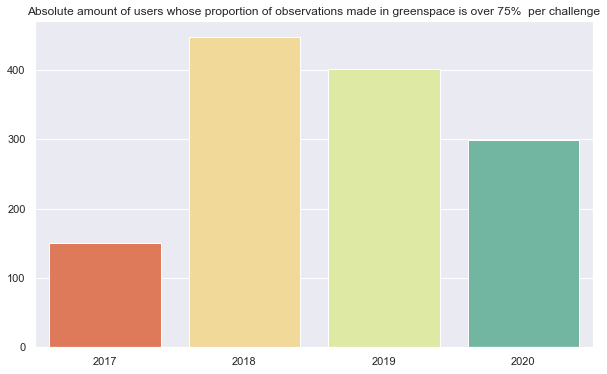

In [29]:
plt.figure(figsize=(10, 6))
plt.title('Absolute amount of users whose proportion of observations made in greenspace is over 75%  per challenge')
ax = sns.barplot(x=years, y=proportions, palette='Spectral')

In [30]:
proportions = [len(new_proportions_17[new_proportions_17.proportion > 0.75])/len(new_proportions_17),
               len(new_proportions_18[new_proportions_18.proportion > 0.75])/len(new_proportions_18), 
               len(new_proportions_19[new_proportions_19.proportion > 0.75])/len(new_proportions_19), 
               len(new_proportions_20[new_proportions_20.proportion > 0.75])/len(new_proportions_20)]

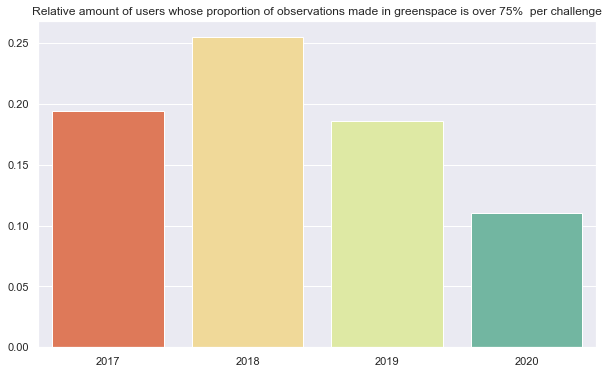

In [31]:
## also relatively compared to the total amount of users in this year 
plt.figure(figsize=(10, 6))
plt.title('Relative amount of users whose proportion of observations made in greenspace is over 75%  per challenge')
sns_plot = sns.barplot(x=years, y=proportions, palette='Spectral')

In [32]:
fig = sns_plot.get_figure()
fig.savefig("sf_greenspace_proportion.png")

In [33]:
prop = pd.DataFrame(list(zip(years, proportions)), columns=['year', 'proportion'])
prop['city'] = 'San Francisco'
prop

,year,proportion,city
0,2017,0.193838,San Francisco
1,2018,0.255271,San Francisco
2,2019,0.186165,San Francisco
3,2020,0.110741,San Francisco


In [34]:
prop.to_csv('sf_proportions.csv')

### Analyze Greenspaces by time

In [11]:
sf_data['observed_on'] = pd.to_datetime(sf_data['time_observed_at']).dt.date

In [16]:
sf_data['observed_on'] = pd.to_datetime(sf_data['observed_on'])

In [17]:
sf_data.observed_on.unique()

array(['2017-04-13T00:00:00.000000000', '2017-04-14T00:00:00.000000000',
       '2017-04-15T00:00:00.000000000', '2017-01-28T00:00:00.000000000',
       '2017-04-16T00:00:00.000000000', '2017-04-17T00:00:00.000000000',
       '2017-04-18T00:00:00.000000000', '2017-04-19T00:00:00.000000000',
       '2017-04-20T00:00:00.000000000', '2017-04-02T00:00:00.000000000',
       '2020-04-24T00:00:00.000000000', '2020-04-25T00:00:00.000000000',
       '2020-04-26T00:00:00.000000000', '2020-04-27T00:00:00.000000000',
       '2020-04-28T00:00:00.000000000', '2019-04-29T00:00:00.000000000',
       '2019-04-27T00:00:00.000000000', '2019-04-26T00:00:00.000000000',
       '2019-04-28T00:00:00.000000000', '2019-04-30T00:00:00.000000000',
       '2018-04-30T00:00:00.000000000', '2018-04-27T00:00:00.000000000',
       '2018-04-28T00:00:00.000000000', '2018-04-29T00:00:00.000000000',
       '2018-05-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [18]:
greenspace_by_date = sf_data.groupby(['observed_on'])['greenspace_flag'].value_counts().to_frame()
greenspace_by_date.rename(columns={'greenspace_flag':'counts'}, inplace=True)
greenspace_by_date.reset_index(inplace=True)
greenspace_by_date['observed_on'] = greenspace_by_date['observed_on'].dt.strftime('%Y-%m-%d')
greenspace_by_date.head()

,observed_on,greenspace_flag,counts
0,2017-01-28,0,1
1,2017-04-02,0,6
2,2017-04-13,0,3
3,2017-04-13,1,1
4,2017-04-14,0,3351


[Text(0, 0, '2017-01-28'),
 Text(1, 0, '2017-04-02'),
 Text(2, 0, '2017-04-13'),
 Text(3, 0, '2017-04-14'),
 Text(4, 0, '2017-04-15'),
 Text(5, 0, '2017-04-16'),
 Text(6, 0, '2017-04-17'),
 Text(7, 0, '2017-04-18'),
 Text(8, 0, '2017-04-19'),
 Text(9, 0, '2017-04-20'),
 Text(10, 0, '2018-04-27'),
 Text(11, 0, '2018-04-28'),
 Text(12, 0, '2018-04-29'),
 Text(13, 0, '2018-04-30'),
 Text(14, 0, '2018-05-01'),
 Text(15, 0, '2019-04-26'),
 Text(16, 0, '2019-04-27'),
 Text(17, 0, '2019-04-28'),
 Text(18, 0, '2019-04-29'),
 Text(19, 0, '2019-04-30'),
 Text(20, 0, '2020-04-24'),
 Text(21, 0, '2020-04-25'),
 Text(22, 0, '2020-04-26'),
 Text(23, 0, '2020-04-27'),
 Text(24, 0, '2020-04-28')]

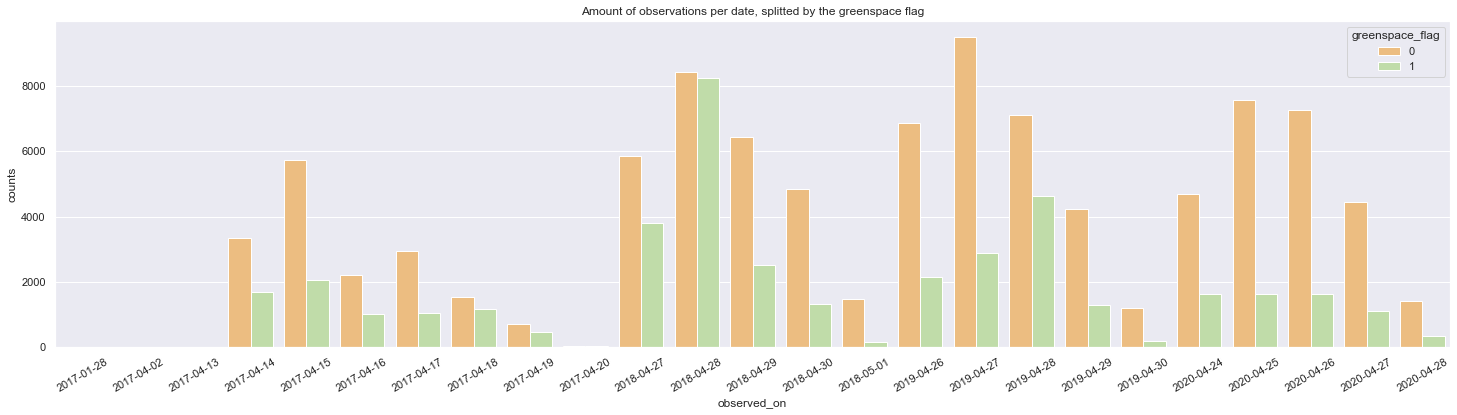

In [20]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(25, 6))
plt.title('Amount of observations per date, splitted by the greenspace flag')
ax = sns.barplot(x='observed_on', y='counts', hue='greenspace_flag', data=greenspace_by_date, palette='Spectral')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

In [21]:
greenspace_by_date.set_index(['observed_on', 'greenspace_flag'], inplace=True)
for date in greenspace_by_date.index.unique(level='observed_on'):
    if (date, 1) in greenspace_by_date.index.unique() and (date, 0) in greenspace_by_date.index.unique():
        greenspace_by_date.loc[(date, 0), 'proportion'] = greenspace_by_date.loc[(date, 0), 'counts'] / (greenspace_by_date.loc[(date, 1), 'counts'] + greenspace_by_date.loc[(date, 0), 'counts'])
        greenspace_by_date.loc[(date, 1), 'proportion'] = greenspace_by_date.loc[(date, 1), 'counts'] / (greenspace_by_date.loc[(date, 1), 'counts'] + greenspace_by_date.loc[(date, 0), 'counts'])
greenspace_by_date.reset_index(inplace=True)
greenspace_by_date.head()

,observed_on,greenspace_flag,counts,proportion
0,2017-01-28,0,1,NaN
1,2017-04-02,0,6,NaN
2,2017-04-13,0,3,0.750000
3,2017-04-13,1,1,0.250000
4,2017-04-14,0,3351,0.663827


[Text(0, 0, '2017-01-28'),
 Text(1, 0, '2017-04-02'),
 Text(2, 0, '2017-04-13'),
 Text(3, 0, '2017-04-14'),
 Text(4, 0, '2017-04-15'),
 Text(5, 0, '2017-04-16'),
 Text(6, 0, '2017-04-17'),
 Text(7, 0, '2017-04-18'),
 Text(8, 0, '2017-04-19'),
 Text(9, 0, '2017-04-20'),
 Text(10, 0, '2018-04-27'),
 Text(11, 0, '2018-04-28'),
 Text(12, 0, '2018-04-29'),
 Text(13, 0, '2018-04-30'),
 Text(14, 0, '2018-05-01'),
 Text(15, 0, '2019-04-26'),
 Text(16, 0, '2019-04-27'),
 Text(17, 0, '2019-04-28'),
 Text(18, 0, '2019-04-29'),
 Text(19, 0, '2019-04-30'),
 Text(20, 0, '2020-04-24'),
 Text(21, 0, '2020-04-25'),
 Text(22, 0, '2020-04-26'),
 Text(23, 0, '2020-04-27'),
 Text(24, 0, '2020-04-28')]

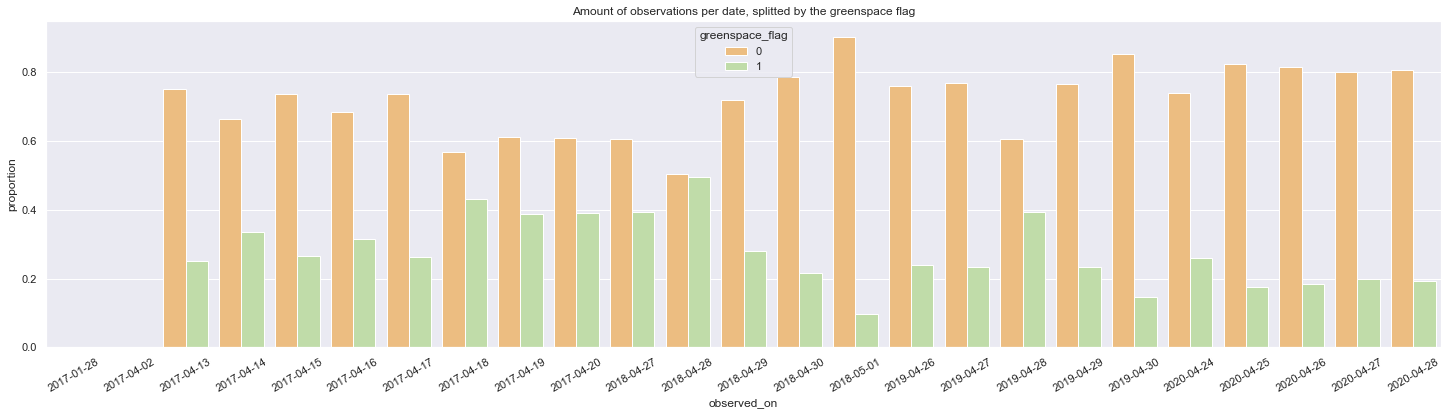

In [24]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(25, 6))
plt.title('Amount of observations per date, splitted by the greenspace flag')
ax = sns.barplot(x='observed_on', y='proportion', hue='greenspace_flag', data=greenspace_by_date, palette='Spectral')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)